## Crossign Accuracy in the EPL

### Imports and Fonts

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval

from PIL import Image
import urllib
import os
import requests
import json

pd.set_option('display.max_columns', None)

# -- For Logos and images
from matplotlib.transforms import Bbox
class BboxLocator:
    def __init__(self, bbox, transform):
        self._bbox = bbox
        self._transform = transform
    def __call__(self, ax, renderer):
        _bbox = self._transform.transform_bbox(self._bbox)
        return ax.figure.transFigure.inverted().transform_bbox(_bbox)

In [313]:
font_path = "D:/pythonProject/Eventos_Brasileirão/src/utils/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if (y.split(".")[-1] == "ttf") or (y.split(".")[-1] == "otf"):
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("D:/pythonProject/Eventos_Brasileirão/src/utils/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'DM Sans'

### Read the data

Here we get detailed statistics for all players in the current season.

In [51]:
data = pd.read_csv('D:/pythonProject/griffis_soccer_analysis/data/final/dados_combinados.csv')
df_players = pd.read_csv('D:/pythonProject/griffis_soccer_analysis/data/processed/2023_br_players.csv')
#juntando as informações dos 2 dfs
data = pd.merge(data, df_players, on='playerId', how='inner')

C:\Users\leojo\AppData\Local\Temp\ipykernel_11112\2822501768.py:1: DtypeWarning: Columns (80,82,84,88,91,96,98,100,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('D:/pythonProject/griffis_soccer_analysis/data/final/dados_combinados.csv')


In [3]:
data = pd.read_json('D:/pythonProject/Eventos_Brasileirão/data/processed/players_events/players_consolidado.json')

In [54]:
data['minutes_played'] = data['minutes_played'].replace(['NA', 'inf'], pd.NA)
data['minutes_played'] = data['minutes_played'].fillna(0).astype(float)

In [55]:
data['dribbles_attempted'] = data['dribbles_attempted'].replace(['NA', 'inf'], pd.NA)
data['dribbles_attempted'] = data['dribbles_attempted'].fillna(0).astype(float)

In [57]:
data['dribbles_succeeded'] = data['dribbles_succeeded'].replace(['NA', 'inf'], pd.NA)
data['dribbles_succeeded'] = data['dribbles_succeeded'].fillna(0).astype(float)

In [59]:
columns_to_fillna = [
    'rating_title', 'matches_started', 'player_sub_in_short', 'player_sub_out_short',
    'yellow_cards', 'goals', 'expected_goals', 'goals_inside_box',
    'goals_rightFootedGoals', 'goals_leftFootedGoals', 'goals_headedGoals',
    'goals_subtitle', 'ShotsOnTarget', 'ShotsOffTarget', 'assists', 'chances_created',
    'total_passes', 'tackles_attempted', 'tackles_succeeded',
    'interceptions', 'goals_conceded', 'expected_goals_on_target_faced',
    'errors_led_to_goal', 'saves', 'penalties_faced', 'saved_penalties',
    'clean_sheet_title', 'goals_outside_box'
]

data[columns_to_fillna] = data[columns_to_fillna].fillna(0)

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   info_player_id                  452 non-null    int64  
 1   info_player_name                452 non-null    object 
 2   info_team_name                  452 non-null    object 
 3   info_team_id                    452 non-null    int64  
 4   info_position                   452 non-null    object 
 5   info_assists                    452 non-null    int64  
 6   info_goals                      452 non-null    int64  
 7   info_matches                    452 non-null    int64  
 8   info_season                     452 non-null    object 
 9   rating_title                    452 non-null    float64
 10  matches_started                 452 non-null    float64
 11  player_sub_in_short             452 non-null    float64
 12  player_sub_out_short            452 

## The Table

In [77]:
def draw_player_image_at_ax(player_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/playerimages/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{player_id:.0f}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

def draw_club_image_at_ax(team_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

## Who gets the most dribbled past?

In [98]:
def get_player_position(info_player_id):
    '''
    This function gets the main player position based on it's Fotmob ID.
    '''

    url = f'https://www.fotmob.com/api/playerData?id={info_player_id}'
    response = requests.get(url)
    content = json.loads(response.content)

    player_positions = content.get('origin').get('positionDesc').get('positions')
    for position in player_positions:
        if position['isMainPosition']:
            return position['strPosShort']
        else:
            continue

In [258]:
data.columns

Index(['info_player_id', 'info_player_name', 'info_team_name', 'info_team_id',
       'info_position', 'info_assists', 'info_goals', 'info_matches',
       'info_season', 'rating_title', 'matches_started', 'player_sub_in_short',
       'player_sub_out_short', 'minutes_played', 'yellow_cards', 'goals',
       'expected_goals', 'goals_inside_box', 'goals_rightFootedGoals',
       'goals_leftFootedGoals', 'goals_headedGoals', 'goals_subtitle',
       'ShotsOnTarget', 'ShotsOffTarget', 'assists', 'chances_created',
       'total_passes', 'dribbles_attempted', 'dribbles_succeeded',
       'tackles_attempted', 'tackles_succeeded',
       'matchstats.headers.clerances', 'interceptions', 'goals_conceded',
       'expected_goals_on_target_faced', 'errors_led_to_goal', 'saves',
       'penalties_faced', 'saved_penalties', 'clean_sheet_title',
       'goals_outside_box'],
      dtype='object')

In [416]:
vars_to_keep = ['dribbles_attempted', 'dribbles_succeeded']
data_groupped = data.copy()
data_groupped = (
    data_groupped[
        (data_groupped['minutes_played'] > 400) &
        (data_groupped[vars_to_keep].notna().any(axis=1))
    ].reset_index(drop=True)
)


In [417]:
data_groupped

,info_player_id,info_player_name,info_team_name,info_team_id,info_position,info_assists,info_goals,info_matches,info_season,rating_title,matches_started,player_sub_in_short,player_sub_out_short,minutes_played,yellow_cards,goals,expected_goals,goals_inside_box,goals_rightFootedGoals,goals_leftFootedGoals,goals_headedGoals,goals_subtitle,ShotsOnTarget,ShotsOffTarget,assists,chances_created,total_passes,dribbles_attempted,dribbles_succeeded,tackles_attempted,tackles_succeeded,matchstats.headers.clerances,interceptions,goals_conceded,expected_goals_on_target_faced,errors_led_to_goal,saves,penalties_faced,saved_penalties,clean_sheet_title,goals_outside_box
0,1227357,Diego Hernandez,Botafogo,8517,AM,0,5,13,2023,0.00,13.0,0.0,5.0,1038.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1317192,Bruninho,Red Bull Bragantino,109705,AM,1,2,13,2023,0.00,8.0,5.0,6.0,665.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,834965,Leonardo Fernandez,Fluminense,9863,AM,12,10,39,2022 - 2023,7.59,15.0,1.0,12.0,1119.0,4.0,5.0,4.4,4.0,0.0,5.0,0.0,2.0,20.0,13.0,7.0,46.0,643.0,44.0,21.0,7.0,3.0,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,629937,Clayson,Cuiaba,197815,AM,1,4,16,2023,7.03,15.0,1.0,13.0,1122.0,1.0,4.0,2.5,4.0,4.0,0.0,0.0,1.0,5.0,13.0,1.0,19.0,345.0,27.0,8.0,16.0,9.0,NaN,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47041,Luiz Adriano,Internacional,8702,AM,1,2,19,2022 - 2023,6.60,15.0,4.0,9.0,1184.0,2.0,2.0,2.5,2.0,1.0,0.0,1.0,0.0,8.0,7.0,1.0,12.0,287.0,5.0,2.0,15.0,13.0,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1138966,Wesley,Cruzeiro,9781,RW,1,4,26,2023,6.93,21.0,5.0,17.0,1699.0,6.0,4.0,4.0,4.0,1.0,3.0,0.0,0.0,14.0,17.0,1.0,16.0,494.0,70.0,38.0,35.0,22.0,NaN,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,988833,Luca Orellano,Vasco da Gama,10276,RW,1,1,18,2023,6.46,6.0,12.0,6.0,619.0,3.0,1.0,1.1,1.0,0.0,1.0,0.0,0.0,5.0,8.0,1.0,11.0,231.0,43.0,23.0,14.0,7.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364,1136605,Diogo,Coritiba,9767,RW,1,6,32,2022 - 2023,6.86,8.0,8.0,1.0,941.0,3.0,4.0,3.2,3.0,2.0,1.0,1.0,0.0,12.0,17.0,1.0,11.0,198.0,26.0,18.0,19.0,11.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,1395944,Kaio,Coritiba,9767,RW,0,0,20,2023,6.43,6.0,14.0,6.0,608.0,3.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,9.0,170.0,30.0,12.0,16.0,14.0,NaN,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [418]:
data_groupped[data_groupped['info_player_name'] == 'Hulk']

,info_player_id,info_player_name,info_team_name,info_team_id,info_position,info_assists,info_goals,info_matches,info_season,rating_title,matches_started,player_sub_in_short,player_sub_out_short,minutes_played,yellow_cards,goals,expected_goals,goals_inside_box,goals_rightFootedGoals,goals_leftFootedGoals,goals_headedGoals,goals_subtitle,ShotsOnTarget,ShotsOffTarget,assists,chances_created,total_passes,dribbles_attempted,dribbles_succeeded,tackles_attempted,tackles_succeeded,matchstats.headers.clerances,interceptions,goals_conceded,expected_goals_on_target_faced,errors_led_to_goal,saves,penalties_faced,saved_penalties,clean_sheet_title,goals_outside_box
354,20276,Hulk,Atletico MG,10272,RW,7,12,29,2023,7.33,28.0,1.0,7.0,2495.0,7.0,12.0,10.4,9.0,1.0,10.0,1.0,4.0,40.0,38.0,7.0,50.0,694.0,128.0,71.0,20.0,15.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [419]:
# data_groupped['total_duels'] = data_groupped['Total aerial duels'] + data_groupped['Total ground duels']
# data_groupped['total_duels_won'] = data_groupped['Aerial duels won'] + data_groupped['Ground duels won']
worst_defenders = data_groupped['dribbles_attempted'].quantile(.75)
data_groupped = data_groupped[data_groupped['dribbles_attempted'] > worst_defenders].reset_index(drop=True)

In [420]:
data_groupped

,info_player_id,info_player_name,info_team_name,info_team_id,info_position,info_assists,info_goals,info_matches,info_season,rating_title,matches_started,player_sub_in_short,player_sub_out_short,minutes_played,yellow_cards,goals,expected_goals,goals_inside_box,goals_rightFootedGoals,goals_leftFootedGoals,goals_headedGoals,goals_subtitle,ShotsOnTarget,ShotsOffTarget,assists,chances_created,total_passes,dribbles_attempted,dribbles_succeeded,tackles_attempted,tackles_succeeded,matchstats.headers.clerances,interceptions,goals_conceded,expected_goals_on_target_faced,errors_led_to_goal,saves,penalties_faced,saved_penalties,clean_sheet_title,goals_outside_box
0,834965,Leonardo Fernandez,Fluminense,9863,AM,12,10,39,2022 - 2023,7.59,15.0,1.0,12.0,1119.0,4.0,5.0,4.4,4.0,0.0,5.0,0.0,2.0,20.0,13.0,7.0,46.0,643.0,44.0,21.0,7.0,3.0,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1110614,Julián Palacios,Goias,9862,AM,1,1,23,2023,6.95,17.0,6.0,13.0,1455.0,6.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,8.0,7.0,1.0,45.0,416.0,70.0,45.0,27.0,16.0,NaN,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,844510,Juninho Capixaba,Red Bull Bragantino,109705,CB,1,2,27,2023,7.65,26.0,1.0,4.0,2338.0,9.0,2.0,1.8,1.0,0.0,1.0,1.0,0.0,15.0,12.0,1.0,44.0,1401.0,42.0,18.0,52.0,39.0,NaN,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1406729,Endrick,Palmeiras,10283,CF,0,8,25,2023,6.76,12.0,13.0,9.0,1100.0,4.0,8.0,6.3,7.0,0.0,6.0,2.0,0.0,17.0,12.0,0.0,10.0,234.0,53.0,25.0,11.0,5.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,614970,Tiquinho Soares,Botafogo,8517,CF,4,16,26,2023,7.44,24.0,2.0,14.0,2038.0,8.0,16.0,11.2,15.0,10.0,2.0,4.0,4.0,29.0,22.0,4.0,26.0,548.0,53.0,32.0,13.0,6.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,339125,Marinho,Fortaleza,8287,RW,1,1,17,2023,6.73,11.0,6.0,9.0,916.0,5.0,1.0,2.7,0.0,0.0,1.0,0.0,0.0,11.0,9.0,1.0,13.0,221.0,35.0,16.0,13.0,9.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,305846,Jonathan Cafu,Cuiaba,197815,RW,3,0,25,2023,6.64,17.0,8.0,17.0,1317.0,3.0,0.0,0.9,0.0,0.0,0.0,0.0,0.0,4.0,7.0,3.0,19.0,420.0,38.0,23.0,27.0,17.0,NaN,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,304856,Pedro Henrique,Internacional,8702,RW,2,1,22,2023,6.73,14.0,8.0,11.0,1191.0,2.0,1.0,3.3,1.0,1.0,0.0,0.0,1.0,7.0,18.0,2.0,14.0,293.0,53.0,22.0,24.0,18.0,NaN,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,1138966,Wesley,Cruzeiro,9781,RW,1,4,26,2023,6.93,21.0,5.0,17.0,1699.0,6.0,4.0,4.0,4.0,1.0,3.0,0.0,0.0,14.0,17.0,1.0,16.0,494.0,70.0,38.0,35.0,22.0,NaN,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [421]:
data_clean = data_groupped.copy()
columns_to_skip = ['info_team_name', 'info_team_id', 'info_player_id', 'info_player_name','info_position', 'minutes_played', 'duel_success']
data_clean = data_clean.assign(duel_success=lambda x: x['dribbles_succeeded'] / x['dribbles_attempted'])

# Converter colunas para tipos numéricos
columns_to_convert = [col for col in data_clean.columns if col not in columns_to_skip]
data_clean[columns_to_convert] = data_clean[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Substituir valores NaN por zero
data_clean[columns_to_convert] = data_clean[columns_to_convert].fillna(0)

# Realizar os cálculos nas colunas apropriadas
for column in data_clean.columns:
    if column in columns_to_skip:
        continue
    else:
        data_clean[column] = (data_clean[column] / data_clean['minutes_played']) * 90


In [422]:
data_clean

,info_player_id,info_player_name,info_team_name,info_team_id,info_position,info_assists,info_goals,info_matches,info_season,rating_title,matches_started,player_sub_in_short,player_sub_out_short,minutes_played,yellow_cards,goals,expected_goals,goals_inside_box,goals_rightFootedGoals,goals_leftFootedGoals,goals_headedGoals,goals_subtitle,ShotsOnTarget,ShotsOffTarget,assists,chances_created,total_passes,dribbles_attempted,dribbles_succeeded,tackles_attempted,tackles_succeeded,matchstats.headers.clerances,interceptions,goals_conceded,expected_goals_on_target_faced,errors_led_to_goal,saves,penalties_faced,saved_penalties,clean_sheet_title,goals_outside_box,duel_success
0,834965,Leonardo Fernandez,Fluminense,9863,AM,0.965147,0.804290,3.136729,0.000000,0.610456,1.206434,0.080429,0.965147,1119.0,0.321716,0.402145,0.353887,0.321716,0.000000,0.402145,0.000000,0.160858,1.608579,1.045576,0.563003,3.699732,51.715818,3.538874,1.689008,0.563003,0.241287,0.0,0.321716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477273
1,1110614,Julián Palacios,Goias,9862,AM,0.061856,0.061856,1.422680,125.134021,0.429897,1.051546,0.371134,0.804124,1455.0,0.371134,0.061856,0.123711,0.061856,0.061856,0.000000,0.000000,0.000000,0.494845,0.432990,0.061856,2.783505,25.731959,4.329897,2.783505,1.670103,0.989691,0.0,0.680412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.642857
2,844510,Juninho Capixaba,Red Bull Bragantino,109705,CB,0.038494,0.076989,1.039350,77.874251,0.294482,1.000855,0.038494,0.153978,2338.0,0.346450,0.076989,0.069290,0.038494,0.000000,0.038494,0.038494,0.000000,0.577417,0.461933,0.038494,1.693755,53.930710,1.616766,0.692900,2.001711,1.501283,0.0,2.771600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571
3,1406729,Endrick,Palmeiras,10283,CF,0.000000,0.654545,2.045455,165.518182,0.553091,0.981818,1.063636,0.736364,1100.0,0.327273,0.654545,0.515455,0.572727,0.000000,0.490909,0.163636,0.000000,1.390909,0.981818,0.000000,0.818182,19.145455,4.336364,2.045455,0.900000,0.409091,0.0,0.081818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471698
4,614970,Tiquinho Soares,Botafogo,8517,CF,0.176644,0.706575,1.148184,89.337586,0.328557,1.059863,0.088322,0.618253,2038.0,0.353288,0.706575,0.494603,0.662414,0.441609,0.088322,0.176644,0.176644,1.280667,0.971541,0.176644,1.148184,24.200196,2.340530,1.413150,0.574092,0.264966,0.0,0.132483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.603774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,339125,Marinho,Fortaleza,8287,RW,0.098253,0.098253,1.670306,198.766376,0.661245,1.080786,0.589520,0.884279,916.0,0.491266,0.098253,0.265284,0.000000,0.000000,0.098253,0.000000,0.000000,1.080786,0.884279,0.098253,1.277293,21.713974,3.438865,1.572052,1.277293,0.884279,0.0,0.294760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457143
87,305846,Jonathan Cafu,Cuiaba,197815,RW,0.205011,0.000000,1.708428,138.246014,0.453759,1.161731,0.546697,1.161731,1317.0,0.205011,0.000000,0.061503,0.000000,0.000000,0.000000,0.000000,0.000000,0.273349,0.478360,0.205011,1.298405,28.701595,2.596811,1.571754,1.845103,1.161731,0.0,0.546697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263
88,304856,Pedro Henrique,Internacional,8702,RW,0.151134,0.075567,1.662469,152.871537,0.508564,1.057935,0.604534,0.831234,1191.0,0.151134,0.075567,0.249370,0.075567,0.075567,0.000000,0.000000,0.075567,0.528967,1.360202,0.151134,1.057935,22.141058,4.005038,1.662469,1.813602,1.360202,0.0,0.377834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.415094
89,1138966,Wesley,Cruzeiro,9781,RW,0.052972,0.211889,1.377281,107.163037,0.367098,1.112419,0.264862,0.900530,1699.0,0.317834,0.211889,0.211889,0.211889,0.052972,0.158917,0.000000,0.000000,0.741613,0.900530,0.052972,0.847557,26.168334,3.708064,2.012949,1.854032,1.165391,0.0,0.635668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542857


In [423]:
data_clean = data_clean[~data_clean['duel_success'].isna()].sort_values(by='dribbles_attempted', ascending=True).reset_index(drop=True)

In [424]:
worst_defenders = data_clean['dribbles_attempted'].quantile(.75)
data_clean = data_clean[data_clean['dribbles_attempted'] > worst_defenders].reset_index(drop=True)

In [197]:
#data_clean['info_position'] = data_clean['info_player_id'].apply(get_player_position)


In [198]:
"""data_clean['info_position'] = [get_player_position(x) for x in data_clean['info_player_id']]
data_clean['info_position'].unique()"""

"data_clean['info_position'] = [get_player_position(x) for x in data_clean['info_player_id']]\ndata_clean['info_position'].unique()"

In [425]:
data_clean = data_clean.tail(30).reset_index(drop=True)

In [184]:
data_clean.at[0, 'position'] = 'LM'

C:\Users\leojo\AppData\Local\Temp\ipykernel_7340\2481508698.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'LM' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_clean.at[0, 'position'] = 'LM'


In [388]:
data_clean['info_position']

0     LB
1     CF
2     LW
3     RW
4     LW
5     LW
6     RW
7     LW
8     LW
9     RW
10    RW
11    RM
12    LW
13    RW
14    LW
Name: info_position, dtype: object

In [270]:
data_clean['info_position'] = data_clean['info_position'].apply(lambda x: x.split())

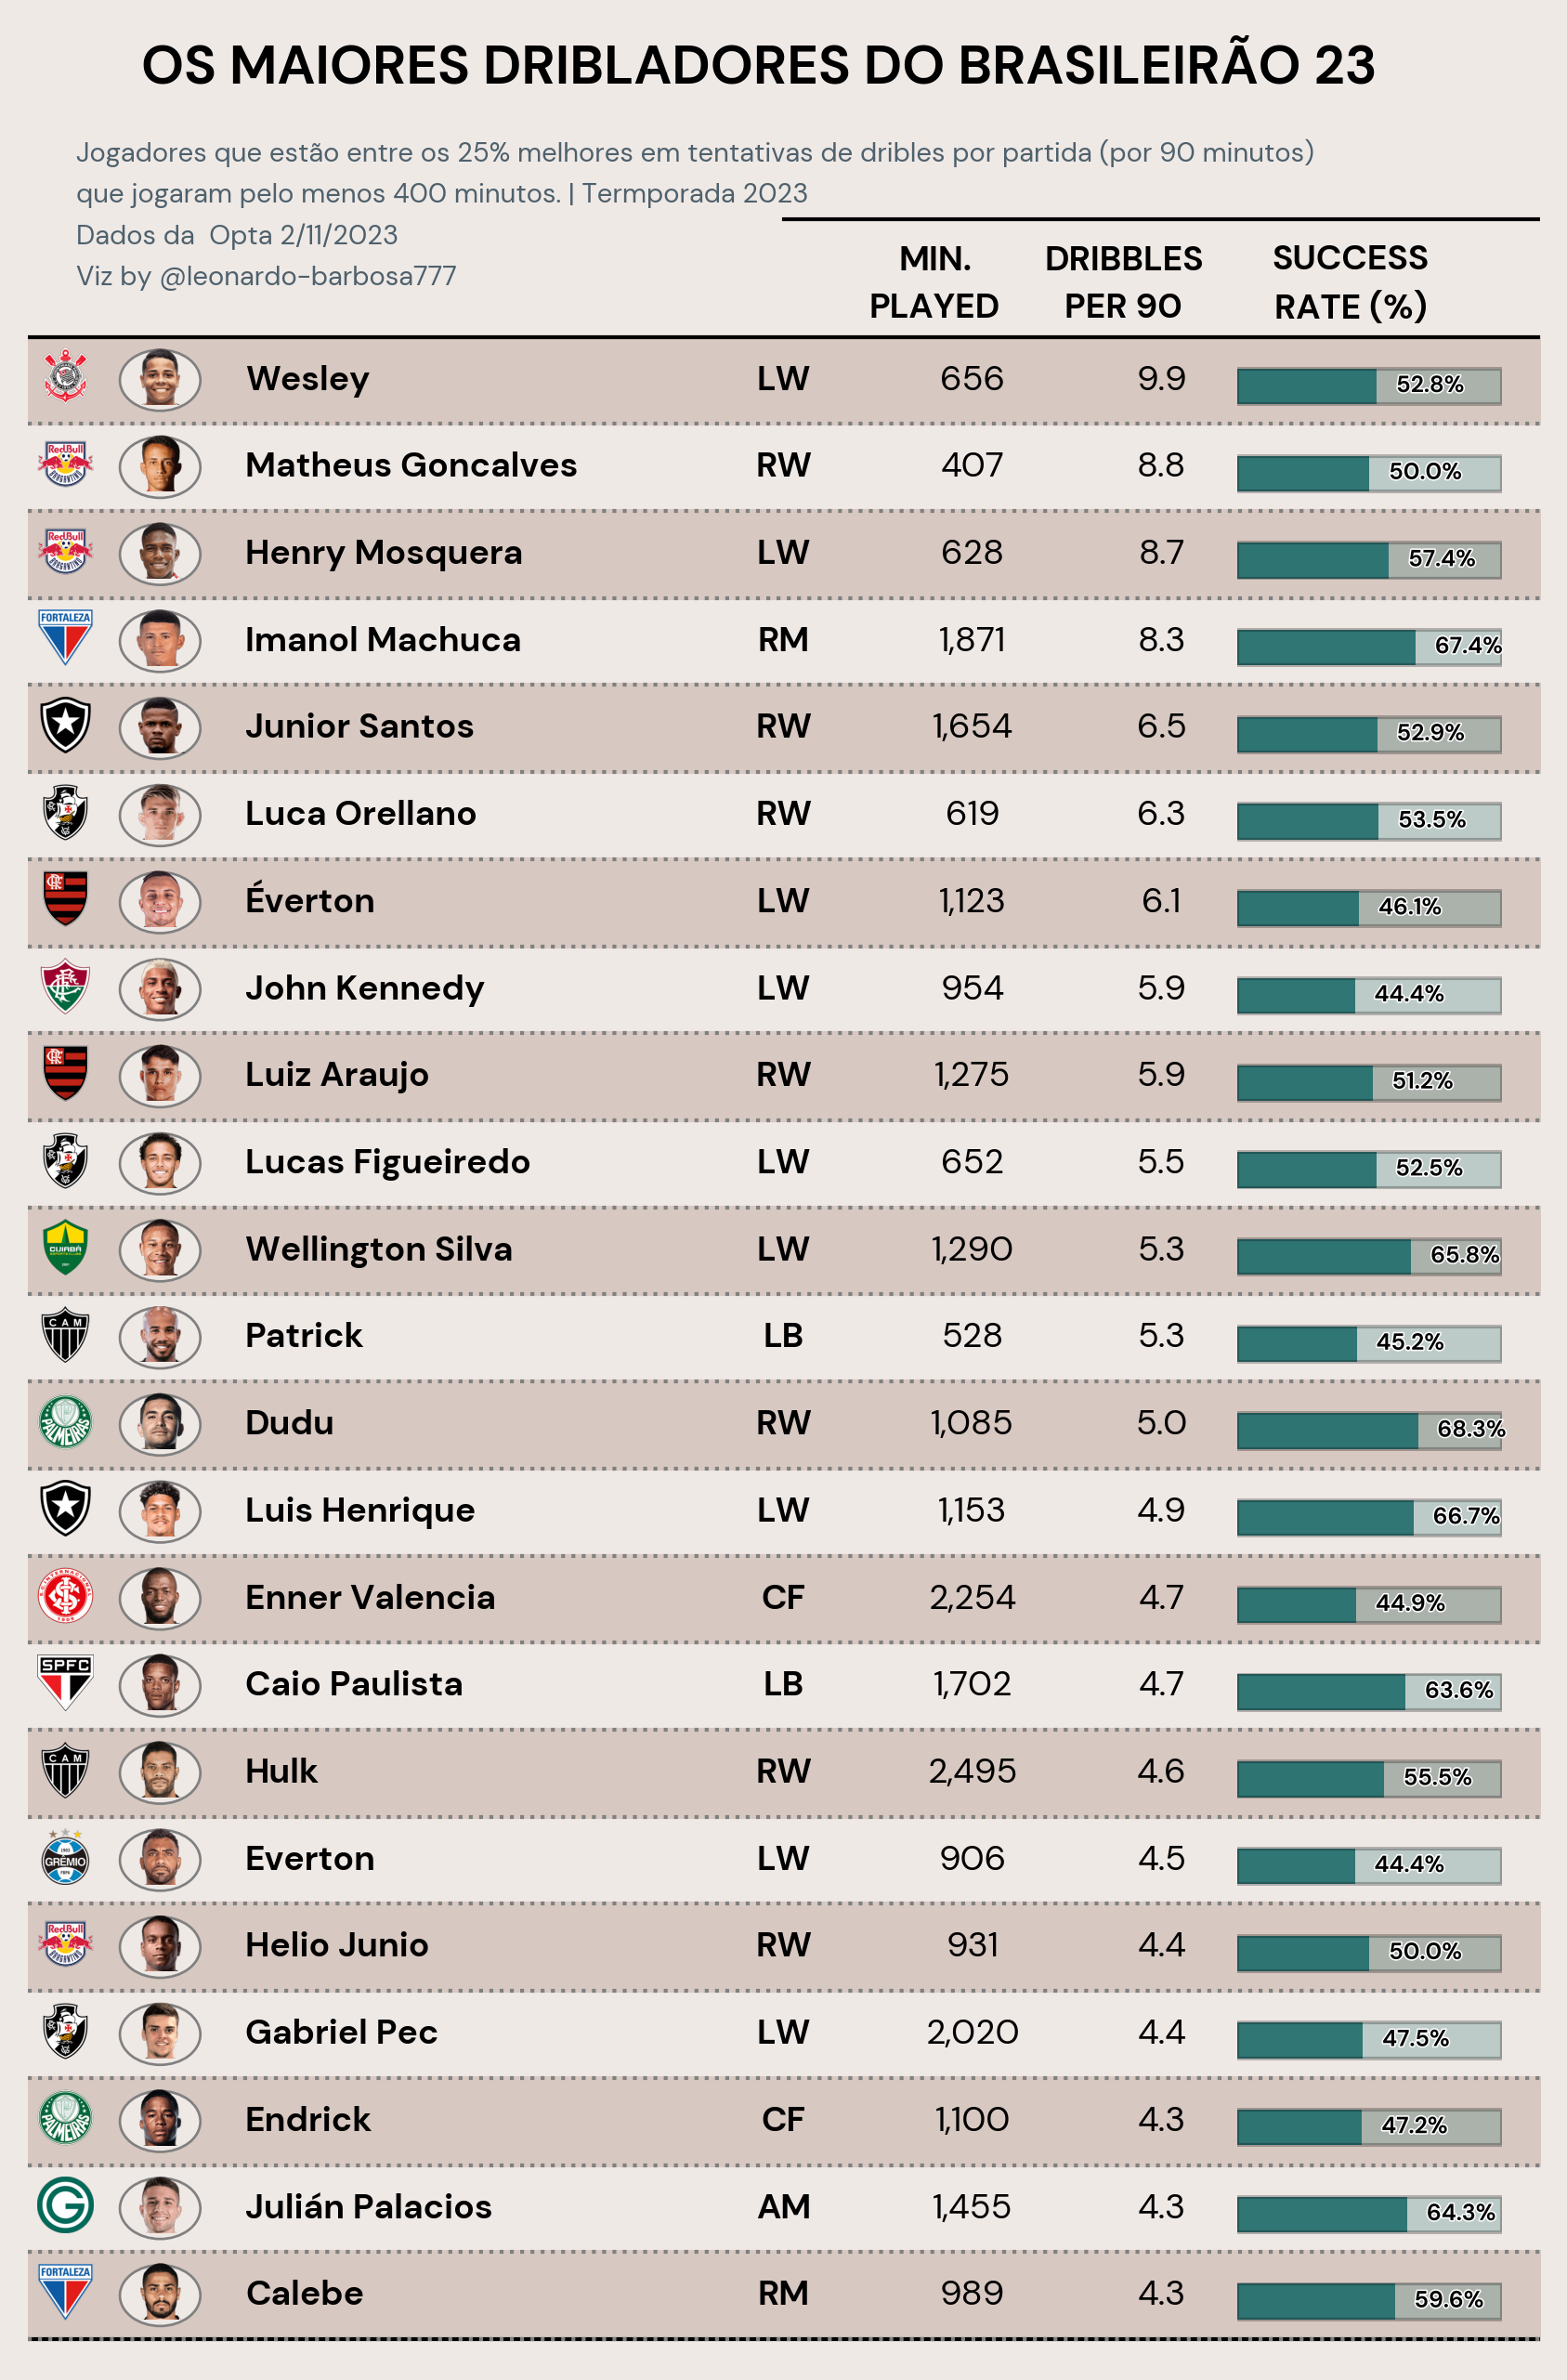

In [427]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()

nrows = data_clean.shape[0]
ncols = data_clean.shape[1] - 3 # because I want to remove aprox. 3 columns from my DF

ax.set_xlim(0, ncols + 1)
ax.set_ylim(-.65, nrows + 1)

# calculate asymmetry of x and y axes: (I have no idea how this works)
x0, y0 = ax.transAxes.transform((0, 0)) # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1)) # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = 1.5 * maxd / dx
height = .7 * maxd / dy

# Iterate
for y in range(0, nrows):
    # -- Club Logo
    bbox = Bbox.from_bounds(0, y - .285, 2, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_club_image_at_ax(data_clean['info_team_id'].iloc[y], logo_ax)
    # -- Player picture
    circle = Ellipse((3.5, y), width, height, ec='grey', fc=fig.get_facecolor(), transform=ax.transData, lw=.65)
    bbox = Bbox.from_bounds(2.5, y - .280, 2, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_player_image_at_ax(data_clean['info_player_id'].iloc[y], logo_ax)
    ax.add_artist(circle)
    # -- Player name
    ax_text(
        x=5.75, y=y,
        s=data_clean['info_player_name'].iloc[y],
        weight='bold', size=9,
        ha='left', va='center', ax=ax,
    )
    # -- Player position
    ax_text(
        x=20, y=y,
        s=str(data_clean['info_position'].iloc[y]),  
        weight='bold', size=9,
        ha='center', va='center', ax=ax
)
    # -- Minutes played
    ax_text(
        x=25, y=y,
        s=f"{data_clean['minutes_played'].iloc[y]:,.0f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Crosses
    ax_text(
        x=30, y=y,
        s=f"{data_clean['dribbles_attempted'].iloc[y]:,.1f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Battery Chart
    bbox = Bbox.from_bounds(32, y - .295, 7, .45)
    battery_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    battery_ax.set_xlim(0,1)
    battery_ax.barh(y=.5, width=data_clean['duel_success'].iloc[y], height=.3, alpha=.95)
    battery_ax.barh(y=.5, width=1, height=.3, alpha=.25, color='#287271', ec='black')
    text_ = battery_ax.annotate(
        xy=(data_clean['duel_success'].iloc[y], .5),
        xytext=(5,0),
        textcoords='offset points',
        text=f"{data_clean['duel_success'].iloc[y]:.1%}",
        ha='left', va='center',
        size=6, weight='bold'
    )
    text_.set_path_effects(
                [path_effects.Stroke(linewidth=.75, foreground="white"), 
                path_effects.Normal()]
            )
    battery_ax.set_axis_off()
    

# -- Draw border lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows - .5, nrows - .5], lw=1, color='black', zorder=3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-.5, -.5], lw=1, color='black', zorder=3)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], y1=x-.5, y2=x+.5, color='#d7c8c1', zorder=-1)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x - .5, x - .5], lw=1, color='grey', ls=':', zorder=3)

ax.set_axis_off()


# -- Column titles
ax_text(
    x=24, y=nrows + .1,
    s='MIN.\nPLAYED',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=29, y=nrows + .1,
    s='DRIBBLES\nPER 90',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=35, y=nrows + .1,
    s='SUCCESS\nRATE (%)',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)

ax.plot([20, ax.get_xlim()[1]], [nrows + .85, nrows + .85], lw=1, color='black', zorder=3)

fig_text(
    x = 0.5, y = .92, 
    s = "OS MAIORES DRIBLADORES DO BRASILEIRÃO 23",
    va = "bottom", ha = "center",
    fontsize = 14, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.15, y = .85, 
    s = "Jogadores que estão entre os 25% melhores em tentativas de dribles por partida (por 90 minutos) \nque jogaram pelo menos 400 minutos. | Termporada 2023 \nDados da  Opta 2/11/2023  \nViz by @leonardo-barbosa777",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#4E616C", font = "DM Sans"
)

plt.savefig(
	"D:/pythonProject/Eventos_Brasileirão/src/images/01092023_epl_dribbles2.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

# plt.savefig(
# 	"figures/01092023_epl_crosses_tr.png",
# 	dpi = 600,
# 	facecolor = "none",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = True
# )